## Лабораторная работа № 2 
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 1

В данной части работы рассмотрены:
* подготовка признаков для рашения задачи **линейной регрессии**;
* создание и обучение модели линейной регрессии;
* оценка качества модели.

#### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [1]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 2 Test Kachurin")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user6/.ivy2/cache
The jars for the packages stored in: /home/user6/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-67024e51-86a1-4660-aff5-d7b4fe7a3dc0;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 795ms :: artifacts dl 25ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

#### Загрузка датасета

Укажем базу данных, которая была создана в первой лабораторной работе.

In [5]:
database_name = "kachurin_database"

Установим созданную базу данных как текущую.

In [6]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем таблицу с **предобработанным датасетом** и загрузим её в `Spark Dataframe`.

In [7]:
df = spark.table("sobd_lab1_processed_table_1")

Выведем прочитанную таблицу на экран.

In [8]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|f38c6c38eddff88d2...|2022-07-01|            ATL|               BOS|         false|       false|    false|320.92999267578125| 368.6000061035156|             1|              947.0|             6|         173|       

Вспомним описание столбцов и параметры датасета, проанализированные в первой лабораторной работе.
Очевидно, что в целях сохранения ясности изложения и сокращения расчетного времени имеет смысл рассматривать не все столбцы датасета. Оставим следующие колонки, удалив остальные:

| Название столбца            | Расшифровка                                                                 |
| --------------------------- | --------------------------------------------------------------------------- |
| legId                       | Идентификатор рейса                                                        |
| flightDate                  | Дата вылета (YYYY-MM-DD)                                                   |
| startingAirport             | Код аэропорта вылета (IATA)                                               |
| destinationAirport          | Код аэропорта прилета (IATA)                                              |
| isBasicEconomy              | Является ли билет экономичным (логическое значение)                       |
| isRefundable                | Является ли билет возвратным (логическое значение)                        |
| isNonStop                   | Является ли рейс прямым (логическое значение)                             |
| baseFare                    | Базовая стоимость билета (в долларах США)                                 |
| totalFare                   | Полная стоимость билета с учетом налогов и сборов (в долларах США)        |
| seatsRemaining              | Количество оставшихся мест                                                |
| totalTravelDistance         | Общая дистанция путешествия (в милях)                                     |


Вспомним схему данных.

In [9]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: float (nullable = true)
 |-- airportFlights: long (nullable = true)
 |-- totalFlights: long (nullable = true)
 |-- otherAirportsFlights: long (nullable = true)
 |-- relativeFlightShareOtherAirports: double (nullable = true)



Вычислим количество строк в датафрейме.

In [10]:
df.count()

30655206

#### Постановка задачи линейной регрессии

Для датасета, заданного представленными колонками, требуется построить модель линейной регрессии для оценки **стоимости автомобиля** по всем остальным признакам. 

Для оценки качества обучения следует использовать метрики $RMSE$ и $R^2$.

#### Подготовка и кодирование признаков

Для корректной работы трансформеров преобразуем столбец `mileage` к типу `DoubleType`.

In [11]:
#df = df.withColumn("mileage", col("mileage").cast(DoubleType()))

Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный `csv`-файл. Он понадобится в следующей лабораторной работе.

In [12]:
def save_sample_to_csv(data: DataFrame, file_path: str, 
                       sample_size: int = 1000) -> DataFrame:
    """
    Сохраняет первые `sample_size` строк из DataFrame в CSV-файл 
    на драйвере и возвращает DataFrame с оставшимися данными.

    Args:
        data (DataFrame): DataFrame, из которого нужно извлечь
            строки.
        file_path (str): Путь для сохранения CSV-файла.
        sample_size (int): Количество строк для сохранения
            (по умолчанию 1000).

    Returns:
        DataFrame: DataFrame с оставшимися данными.
    """
    # Определяем пропорции для разделения
    sample_fraction = sample_size / data.count()
    remaining_fraction = 1 - sample_fraction

    # Разделяем DataFrame на два непересекающихся набора данных
    sample_data, remaining_data = data.randomSplit(
        [sample_fraction, remaining_fraction]
    )

    # Сохраняем извлеченные строки в CSV-файл на драйвере
    try:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.writer(file)

            # Записываем заголовок
            writer.writerow(data.columns)

            # Записываем строки
            for row in sample_data.take(sample_size):
                writer.writerow(row)
        print(f"Файл \"{file_path}\" с данными успешно создан.")

    except Exception as e:
        print(f"Ошибка при записи файла: {e}")

    return remaining_data

Определяем путь для сохранения `csv`-файла.

In [13]:
path = "streaming-data_1.csv"

df = save_sample_to_csv(data=df, file_path=path, sample_size=1000)

Файл "streaming-data_1.csv" с данными успешно создан.


Оцениваем, сколько строк в датасете осталось.

In [14]:
df.count()

30654171

Разделим датасет на обучающую и тестовую выборки.

In [15]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [16]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 24525913


Test  dataset size: 6128258


Понятно, что **идентификационный номер** автомобиля не оказывает влияния на цену. Использовать его в модели нет смысла.

Остальные признаки сгруппируем по их типу:

* **Категориальные** признаки не содержат большого количества категорий, закодируем их `one-hot`-кодировкой.
* **Бинарные** признаки представлены значениями `true` / `false`, которые могут быть интерпретированы как единица и нуль. Поэтому, в кодировании не нуждаются.
* **Количественные** признаки нужно нормализовать / стандартизировать, перед тем, как передавать их в модель.
* Среди количественных признаков выделяется `mileage`, который по своим значениям больше напоминает бинарный. **Бинаризуем** его по порогу `100`.

In [17]:
categorical_features = ["startingAirport", "destinationAirport"]
binary_features = ["isBasicEconomy", "isRefundable", "isNonStop"]
numeric_features = ["seatsRemaining", "totalTravelDistance", 
                    "airportFlights", "totalFlights"]

Создадим конвейер обработки данных, включающий модель линейной регрессии.

In [18]:
def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    binary_features: list[str], label_col: str, num_trees: int, max_depth: int) -> Pipeline:
    
    # Формируем названия колонок для индексированных категориальных признаков
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    
    # Выполняем преобразования данных
    string_indexer = StringIndexer(inputCols=categorical_features,
                                   outputCols=indexed_categorical_features,
                                   handleInvalid="keep")
    
    # Сборка всех признаков в единый вектор
    vector_all_assembler = VectorAssembler(
        inputCols=(indexed_categorical_features + numeric_features + binary_features),
        outputCol="features"
    )

    # Создаем модель случайного леса
    random_forest = RandomForestRegressor(featuresCol="features",
                                          labelCol=label_col,
                                          predictionCol="prediction",
                                          numTrees=num_trees,
                                          maxDepth=max_depth)

    # Создаем конвейер
    pipeline = Pipeline(stages=[
        string_indexer, vector_all_assembler, random_forest
    ])

    return pipeline

In [19]:
# def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
#                     binary_features: list[str], binarized_col: str, 
#                     threshold: float, label_col: str, max_iter: int) -> Pipeline:
    
#     # Формируем названия колонок для преобразованных признаков
#     indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
#     onehot_categorical_features = [f"{feature}_ohe" for feature in categorical_features]
    
#     # Выполняем преобразования данных
#     string_indexer = StringIndexer(inputCols=categorical_features,
#                                    outputCols=indexed_categorical_features,
#                                    handleInvalid="keep")
#     onehot_encoder = OneHotEncoder(inputCols=indexed_categorical_features,
#                                    outputCols=onehot_categorical_features,
#                                    dropLast=True,
#                                    handleInvalid="keep")
#     vector_num_assembler = VectorAssembler(inputCols=numeric_features,
#                                            outputCol="numeric_vector")
#     numeric_scaler = MinMaxScaler(inputCol="numeric_vector",
#                                    outputCol="numeric_vector_scaled")
#     binarizer = Binarizer(inputCol=binarized_col,
#                           outputCol="mileage_binary",
#                           threshold=threshold)
#     vector_all_assembler = VectorAssembler(
#         inputCols=(onehot_categorical_features + binary_features +
#                    ["numeric_vector_scaled", "mileage_binary"]),
#         outputCol="features"
#     )

#     # Создаем модель линейной регрессии
#     linear_regression = LinearRegression(featuresCol="features",
#                                          labelCol=label_col,
#                                          predictionCol="prediction",
#                                          standardization=False,
#                                          maxIter=max_iter)

#     # Создаем конвейер
#     pipeline = Pipeline(stages=[
#         string_indexer, onehot_encoder, vector_num_assembler,
#         numeric_scaler, binarizer, vector_all_assembler,
#         linear_regression
#     ])

#     return pipeline

In [20]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           binary_features=binary_features,
                           label_col="totalFare",  #"totalFare"
                           num_trees=15,            # Число деревьев
                           max_depth=10)            # Максимальная глубина дерева


#### Обучение модели

Выполним **подбор гиперпараметров** модели линейной регрессии с помощью кросс-валидации на сетке.

Создаем сетку параметров для кросс-валидации, получив объект `LinearRegression` из конвейера.

In [21]:
# param_grid = ParamGridBuilder() \
#     .addGrid(pipeline.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
#     .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
#     .build()

In [22]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].numTrees, [10, 20, 30]) \
    .addGrid(pipeline.getStages()[-1].maxDepth, [5, 10, 15]) \
    .build()

In [23]:
# param_grid = ParamGridBuilder() \
#     .addGrid(pipeline.getStages()[-1].numTrees, [10, 20, 30]) \
#     .addGrid(pipeline.getStages()[-1].maxDepth, [5, 10, 15]) \
#     .addGrid(pipeline.getStages()[-1].maxBins, [32, 64, 128]) \
#     .addGrid(pipeline.getStages()[-1].minInstancesPerNode, [1, 5, 10]) \
#     .build()

Создаем экземпляр `RegressionEvaluator` для оценки модели.

In [24]:
cv_evaluator = RegressionEvaluator(labelCol="totalFare", 
                                   predictionCol="prediction",
                                   metricName="rmse") 

Создаем объект `CrossValidator`.

In [25]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5) 

Обучаем модель конвейера с использованием кросс-валидации.

In [26]:
cv_model = cross_validator.fit(train_df)

24/12/16 17:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1761.3 KiB
24/12/16 17:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1761.3 KiB
24/12/16 17:49:14 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/12/16 17:50:19 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/12/16 17:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1367.4 KiB
24/12/16 17:51:49 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/16 17:53:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/12/16 17:53:33 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
24/12/16 17:55:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/12/16 17:55:29 WARN DAGScheduler: Broadcasting large task binary with size 24.4 MiB
24/12/16 17:57:28 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/12/16 18:09:17 WARN DAGScheduler: Broadc

Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [46]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    # Извлечение лучшей модели из CrossValidator
    best_model_pipeline = cv_model.bestModel  # Это PipelineModel
    
    # Извлечение последнего этапа из Pipeline
    rf_model = best_model_pipeline.stages[-1]  # RandomForestRegressionModel
    
    # Проверка, что это действительно RandomForestRegressionModel
    from pyspark.ml.regression import RandomForestRegressionModel
    if not isinstance(rf_model, RandomForestRegressionModel):
        raise ValueError("Последний этап Pipeline не является RandomForestRegressionModel")
    
    # Извлечение параметров модели из ParamMap
    param_map = rf_model.extractParamMap()
    best_params = {
        "numTrees": param_map[rf_model.getParam("numTrees")],  # Количество деревьев
        "maxDepth": param_map[rf_model.getParam("maxDepth")],  # Максимальная глубина
        "maxBins": param_map[rf_model.getParam("maxBins")]     # Количество бинов
    }
    return best_params

In [47]:
# Вывод параметры лучшей модели
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

numTrees: 30
maxDepth: 15
maxBins: 32


In [58]:
# def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
#     """
#     Получает параметры лучшей модели из объекта CrossValidatorModel.

#     Args:
#         cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
#             содержащий лучшую модель.

#     Returns:
#         Dict[str, float]: Параметры лучшей модели.
#     """
#     best_model = cv_model.bestModel
#     best_params = {
#         "regParam": best_model.stages[-1].getRegParam(),
#         "elasticNetParam": best_model.stages[-1].getElasticNetParam(),
#         "maxIter": best_model.stages[-1].getMaxIter()
#     }
#     return best_params

In [ ]:
# for key, value in get_best_model_params(cv_model=cv_model).items():
#     print(f"{key}: {value}")

#### Анализ процесса обучения

Визуализируем изменение ошибки модели в ходе обучения и рассчитаем метрики на обучающем датасете.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_importance(cv_model: CrossValidatorModel) -> None:
    """
    Отображает график важности признаков для лучшей модели.
    
    Args:
        cv_model (CrossValidatorModel): Обученная модель с использованием кросс-валидации.
    """
    # Получаем лучшую модель
    best_model = cv_model.bestModel

    # Извлекаем важность признаков
    feature_importances = best_model.stages[-1].featureImportances

    # Преобразуем важности признаков в список
    feature_importances = feature_importances.toArray()  # Преобразуем DenseVector в массив

    # Получаем имена признаков
    feature_names = best_model.stages[-2].getInputCols()  # Список признаков

    # Убедимся, что длины совпадают
    assert len(feature_names) == len(feature_importances), "Размеры имен и важностей признаков не совпадают!"

    # Создаем DataFrame для удобства отображения
    importances_df = {
        'Feature': feature_names,
        'Importance': feature_importances
    }

    # Строим график
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_df['Feature'], y=importances_df['Importance'])
    plt.xlabel('Признаки')
    plt.ylabel('Важность')
    plt.title("Важность признаков для модели RandomForest")
    plt.xticks(rotation=90)
    plt.show()


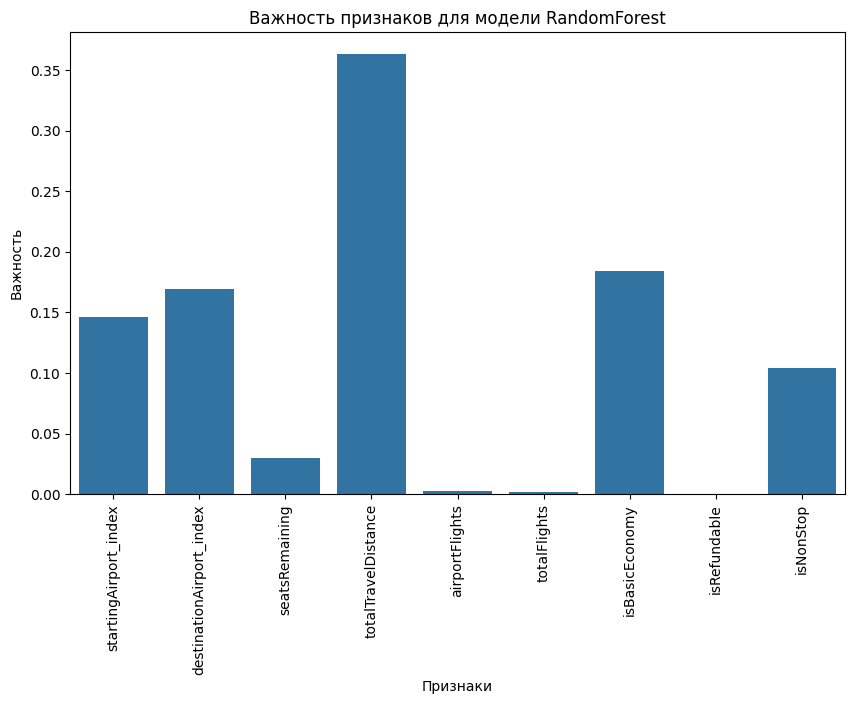

In [51]:
plot_feature_importance(cv_model=cv_model)

In [52]:
# def plot_training_summary(cv_model: DataFrame) -> None:
#     """
#     Отображает графики зависимости значения ошибки от номера итерации на
#     обучающей выборке, а также значения метрик RMSE и R^2.

#     Args:
#         cv_model (DataFrame): Обученная модель с использованием кросс-валидации.
#     """
#     # Получаем лучшую модель
#     best_model = cv_model.bestModel

#     # Получаем информацию о процессе обучения
#     training_summary = best_model.stages[-1].summary

#     # Получаем значения ошибки для каждой итерации
#     objective_history = training_summary.objectiveHistory

#     # Строим график зависимости значения ошибки от номера итерации
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(x=range(len(objective_history)), 
#                  y=objective_history, 
#                  marker='o')
#     plt.xlabel('Итерация')
#     plt.ylabel('Ошибка')
#     plt.title("Зависимость значения функции ошибки от номера итерации")

#     # Получаем значения метрик
#     rmse = training_summary.rootMeanSquaredError
#     r2 = training_summary.r2

#     # Добавляем значения метрик на график
#     plt.text(0.95, 0.95, f"RMSE: {rmse:.2f}\nR^2: {r2:.2f}",
#              transform=plt.gca().transAxes, ha='right', va='top',
#              bbox=dict(facecolor='white', alpha=0.8), zorder=5)
#     plt.grid()

#     plt.show()

In [53]:
#plot_training_summary(cv_model)

#### Проверка обобщающей способности модели

Выполним предсказания на тестовой выборке. 

Перегруппируем колонки датафрейма, переставив столбец с ценой автомобиля в конец, чтобы его значения было удобно сравнивать с предсказанными.

In [54]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("totalFare")  
right_columns_order.append("totalFare")  

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+---------------------+------------------------+--------------------+------------------+------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|startingAirport_index|destinationAirport_index|            features|        prediction|         totalFare|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+---------------------+------------------------+-------------

In [55]:
# # Получаем датасет предсказаний
# test_df_predictions = cv_model.transform(test_df)

# # Извлекаем список колонок, устанавливаем цену на последнее место
# right_columns_order = test_df_predictions.columns
# right_columns_order.remove("price")
# right_columns_order.append("price")

# # Изменяем последовательность колонок и выводим датафрейм
# test_df_predictions = test_df_predictions.select(*right_columns_order)
# test_df_predictions.show()

Создадим функцию оценки модели: расчета метрик для некоторого датасета, как правило, тестового.

In [56]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").
    
    Returns:
        float: Значение указанной метрики.
    """
    # Оценка регрессионной модели с использованием столбца 'totalFare' как целевой переменной
    evaluator = RegressionEvaluator(labelCol="totalFare", 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    
    return metric_value


Оценим модель на тестовой выборке.

In [57]:
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE on test data: {test_rmse:.2f}")
print(f"R^2 on test data: {test_r2:.2f}")

RMSE on test data: 108.44
R^2 on test data: 0.57


Метрики весьма неплохие для линейной модели!

#### Сохранение модели

Зададим директорию студента в `HDFS`, в которой будет сохранена обученная модель.

In [58]:
student_hdfs_folder = "kachurin_directory"

In [59]:
# Получаем имя пользователя
user_name = os.getenv("USER")

# Путь модели в HDFS
model_hdfs_path = f"hdfs:///user/{user_name}/{student_hdfs_folder}/models/lr-model"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.save(model_hdfs_path)
    print(f"Модель успешно сохранена в \"{model_hdfs_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

24/12/17 06:51:10 WARN TaskSetManager: Stage 1387 contains a task of very large size (1801 KiB). The maximum recommended task size is 1000 KiB.


Модель успешно сохранена в "hdfs:///user/user6/kachurin_directory/models/lr-model"


Не забываем завершать `Spark`-сессию.

In [60]:
spark.stop()